# Import important libraries

In [1058]:
import time
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from math import *
import math
from datetime import datetime, timedelta
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.ticker import MaxNLocator
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from keras.utils import plot_model
import keras
import plotly.graph_objects as go
import math
import plotly.subplots as sp
import plotly.graph_objects as go



mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Import inventory management files : GKT

Imporatation des données de la gestion de stock de toutes les années en un data frame

In [1059]:
data_GKT_2021_2024 = pd.read_csv('sortie_stock_GKT_2021_2024.csv', encoding='ISO-8859-1', delimiter=';')

data_GKT_2018_2020 = pd.read_csv('sortie_stock_GKT_2018_2020.csv', encoding='ISO-8859-1', delimiter=';')

data_GKT_2015_2017 = pd.read_csv('sortie_stock_GKT_2015_2017.csv', encoding='ISO-8859-1', delimiter=';')

data_GKT_2010_2014 = pd.read_csv('sortie_stock_GKT_2010_2014.csv', encoding='ISO-8859-1', delimiter=';')

result_append_1 = pd.concat([data_GKT_2021_2024, data_GKT_2018_2020])
result_append_2 = pd.concat([data_GKT_2015_2017, data_GKT_2010_2014])

data_GKT = pd.concat([result_append_1, result_append_2])

data_GKT = data_GKT[(data_GKT["Type de transaction"].isin(["Retour d'article", "Sortie d'article"]))]

data_GKT['Date de sortie'] = pd.to_datetime(data_GKT['Date de sortie'], format='%d/%m/%Y')


data_GKT["Quantité sortie"] = pd.to_numeric(data_GKT["Quantité sortie"], errors='coerce')

# Drop the rows with NaN values
data_GKT.dropna(subset=["Quantité sortie"], inplace=True)

data_GKT["Quantité sortie"] = data_GKT["Quantité sortie"].astype(int)


# Drop the rows with NaN values
data_GKT.dropna(subset=['Quantité sortie'], inplace=True)


# data_GKT.to_excel('merged_data_stock.xlsx', index=False)
# print("Résultat exporté en Excel.")

# print('Data type of each column of Dataframe :')
# data_GKT.info(verbose=True)


c:\temp\ipykernel_26724\1638997204.py:5: DtypeWarning:

Columns (1,23,24,32,35,45) have mixed types. Specify dtype option on import or set low_memory=False.



Transformer les codes articles en code description

In [1060]:
ref_pieces = pd.read_csv('ref_pieces.csv', encoding='ISO-8859-1', delimiter=';')

# Create an empty dictionary
data_dict = {}

# Iterate over the rows of the DataFrame
for index, row in ref_pieces.iterrows():
    name = row['PARTS']
    ref1 = row['Ref Berco']
    ref2 = row['CAT']
    
    # Add the name as the key and the values of ref1 and ref2 as the value to the dictionary
    data_dict[ref1] = (name)
    data_dict[ref2] = (name)

# print(data_dict)

data_GKT['Code article'] = data_GKT['Code article'].replace(data_dict)


# data_GKT.to_excel('data_compartiment.xlsx', index=False)
# print("Résultat exporté en Excel.")

# print('Data type of each column of Dataframe :')
# data_GKT.info(verbose=True)

changer le fichier des references des pieces pour garder que la description unique

In [1061]:
ref_pieces.drop_duplicates(subset=['PARTS'])

ref_pieces['modified_PARTS'] = ref_pieces['PARTS'].apply(lambda x: x.replace(' ', '_'))

# ref_pieces['modified_PARTS'] = ref_pieces['CAT']
# ref_pieces.to_excel('ref_pieces_modifié.xlsx', index=False)
# print("Résultat exporté en Excel.")

# print('Data type of each column of Dataframe :')
# ref_pieces.info(verbose=True)

In [1062]:
for index in range(ref_pieces.shape[0]):
    
    data_GKT_cop = data_GKT[(data_GKT["Code article"].isin([ref_pieces.at[index, 'PARTS']]))]

    data_group = data_GKT_cop.groupby(['Bon de sortie', 'Code article' ], as_index=False)["Quantité sortie"].sum()

    data_GKT_cop = data_GKT_cop.drop(columns = ['Quantité sortie'])
    data_GKT_cop = data_GKT_cop.sort_values(by=['Date de sortie'])
    data_GKT_cop = data_GKT_cop.drop_duplicates(subset=["Bon de sortie","Code article"],keep='first')

    data_stock_GKT = pd.merge(data_GKT_cop, data_group,how="right", on=["Bon de sortie","Code article"])
    data_stock_GKT = data_stock_GKT.sort_values(by=['Date de sortie'])


    grouped = data_stock_GKT.groupby(["N° d'OT destinataire", 'Code article'])

    data_stock_GKT_drop = data_stock_GKT
    data_stock_GKT_join = data_stock_GKT
    for (ot, Code_article), group in grouped:
        
        filtered_group = group[group['Quantité sortie'] < 0]
        # print(filtered_group)
        if not filtered_group.empty:
                    # Get the index of rows with negative 'Quantité sortie'
            negative_rows_index = filtered_group.index.tolist()
            # print(negative_rows_index)
            
            # print(filtered_group)
            
            for negative_value_index in range(len(negative_rows_index)):
                # last_negative_row_index = negative_rows_index[-1]
                negative_value = negative_rows_index[negative_value_index]
                print(negative_value)
                # condition = (group['Quantité sortie'] > 0) & (group['Date de sortie'] < group['Date de sortie'].values[negative_value])
                condition1 = (group['Quantité sortie'] == abs( data_stock_GKT.loc[negative_value]['Quantité sortie'])) & (group["N° de transaction"] < data_stock_GKT.loc[negative_value]["N° de transaction"])
                positive_rows_condition_1 = group[condition1]
                if not positive_rows_condition_1.empty:
                    positive_rows = positive_rows_condition_1
                    positive_rows = positive_rows.sort_values(by=["N° de transaction"], ascending=False)
                    positive_rows_index = positive_rows.index.tolist()
                    first_positive_row_index = positive_rows_index[0]
                    # print(first_positive_row_index)
                    positive_row = positive_rows.head(1)
                    # print(positive_row)
                    positive_row.loc[:, 'Quantité sortie'] = positive_row['Quantité sortie'] + data_stock_GKT.loc[negative_value]['Quantité sortie']
                    # print(positive_row)
                    # print(first_positive_row_index)
                    
                    
                    data_stock_GKT_join = pd.merge(data_stock_GKT_join,positive_row,how='outer')

                    # data_stock_GKT_drop = data_stock_GKT.drop(1)

                    data_stock_GKT_drop = data_stock_GKT_drop.drop(negative_value)
                    # # print(first_positive_row_index)
                    data_stock_GKT_drop = data_stock_GKT_drop.drop(first_positive_row_index)
                else:
                    condition2 = (group['Quantité sortie'] > abs( data_stock_GKT.loc[negative_value]['Quantité sortie'])) & (group["N° de transaction"] < data_stock_GKT.loc[negative_value]["N° de transaction"])
                    positive_rows_condition_2 = group[condition2]
                    if not positive_rows_condition_2.empty:
                        positive_rows = positive_rows_condition_2
                        positive_rows = positive_rows.sort_values(by=["N° de transaction"], ascending=False)
                        positive_rows_index = positive_rows.index.tolist()
                        first_positive_row_index = positive_rows_index[0]
                        # print(first_positive_row_index)
                        positive_row = positive_rows.head(1)
                        # print(positive_row)
                        positive_row.loc[:, 'Quantité sortie'] = positive_row['Quantité sortie'] + data_stock_GKT.loc[negative_value]['Quantité sortie']
                        # print(positive_row)
                        # print(first_positive_row_index)
                        
                        
                        data_stock_GKT_join = pd.merge(data_stock_GKT_join,positive_row,how='outer')

                        # data_stock_GKT_drop = data_stock_GKT.drop(1)

                        data_stock_GKT_drop = data_stock_GKT_drop.drop(negative_value)
                        # # print(first_positive_row_index)
                        data_stock_GKT_drop = data_stock_GKT_drop.drop(first_positive_row_index)

            
    join_stock_join_right = data_stock_GKT.merge(data_stock_GKT_join, how='outer', indicator=True)
    join_stock_join_right = join_stock_join_right[join_stock_join_right['_merge'] == 'right_only']
    join_stock_join_right.drop(columns='_merge',inplace = True)

    stock_piece = join_stock_join_right.merge(data_stock_GKT_drop, how='outer')
    data_stock_GKT = stock_piece



    data_stock_GKT['date_mois'] = data_stock_GKT['Date de sortie'].dt.strftime('%Y-%m')

    # piece_column = ref_pieces.at[0, 'modified_PARTS']

    data_stock_GKT = data_stock_GKT.groupby("date_mois", as_index=False).agg(
    piece_column = pd.NamedAgg("Quantité sortie","sum")
    )
    data_stock_GKT = data_stock_GKT.rename(columns={'piece_column': ref_pieces.at[index, 'modified_PARTS']})

    

    if index == 0 : 
        data_stock_GKT_final = data_stock_GKT
    else:
        data_stock_GKT_final = pd.merge(data_stock_GKT_final,data_stock_GKT,how='outer')

    data_GKT_cop = data_GKT


print('Data type of each column of Dataframe :')
data_stock_GKT_final.info(verbose=True)

# data_stock_GKT_final.to_excel('Regrouper_stock_mois.xlsx', index=False)
# print("Résultat exporté en Excel.")

27
13
26
14
11
108
0
250
143
250
143
141
141
9
164
0
84
0
84
312
316
214
88
173
173
232
232
Data type of each column of Dataframe :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 24 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   date_mois                                      120 non-null    object 
 1   CHAINES_TUILEES_AVEC_TUILES_7T2288_(560mm_ES)  41 non-null     float64
 2   SEGMENT                                        20 non-null     float64
 3   BOLT_FOR_SEGMENT                               51 non-null     float64
 4   NUT_FOR_SEGMENT                                58 non-null     float64
 5   WASHER_SEGMENT                                 0 non-null      float64
 6   GUIDES_CHAINES                                 89 non-null     float64
 7   BOLT                                           85 non-null     float64
 8 

In [1063]:

# for index in range(ref_pieces.shape[0]):
    
#     data_GKT_cop = data_GKT[(data_GKT["Code article"].isin([ref_pieces.at[index, 'PARTS']]))]

#     data_group = data_GKT_cop.groupby(['Bon de sortie', 'Code article' ], as_index=False)["Quantité sortie"].sum()

#     data_GKT_cop = data_GKT_cop.drop(columns = ['Quantité sortie'])
#     data_GKT_cop = data_GKT_cop.sort_values(by=['Date de sortie'])
#     data_GKT_cop = data_GKT_cop.drop_duplicates(subset=["Bon de sortie","Code article"],keep='first')

#     data_stock_GKT = pd.merge(data_GKT_cop, data_group,how="right", on=["Bon de sortie","Code article"])
#     data_stock_GKT = data_stock_GKT.sort_values(by=['Date de sortie'])

#     data_stock_GKT['date_mois'] = data_stock_GKT['Date de sortie'].dt.strftime('%Y-%m')

#     # piece_column = ref_pieces.at[0, 'modified_PARTS']

#     data_stock_GKT = data_stock_GKT.groupby("date_mois", as_index=False).agg(
#     piece_column = pd.NamedAgg("Quantité sortie","sum")
#     )
#     data_stock_GKT = data_stock_GKT.rename(columns={'piece_column': ref_pieces.at[index, 'modified_PARTS']})

    

#     if index == 0 : 
#         data_stock_GKT_final = data_stock_GKT
#     else:
#         data_stock_GKT_final = pd.merge(data_stock_GKT_final,data_stock_GKT,how='outer')

#     data_GKT_cop = data_GKT


# # print('Data type of each column of Dataframe :')
# # data_stock_GKT_final.info(verbose=True)

# data_stock_GKT_final.to_excel('Regrouper_stock_mois.xlsx', index=False)
# print("Résultat exporté en Excel.")

# Import compteur mensuel files : GKT

In [1064]:
data_compteur_GKT = pd.read_csv('compteur_mensuel_GKT.csv', encoding='ISO-8859-1', delimiter=';')
D9 = ['D9'] 
data_compteur_GKT = data_compteur_GKT[(data_compteur_GKT['Modèle'].isin(D9))]

data_compteur_GKT['date'] = data_compteur_GKT['Année'].astype(str) + '-' + data_compteur_GKT['Mois'].astype(str)

data_compteur_GKT['date'] = pd.to_datetime(data_compteur_GKT['date'], format='%Y-%m')

data_compteur_GKT['date_mois'] = data_compteur_GKT['date'].dt.strftime('%Y-%m')

# Créer un masque booléen pour filtrer les lignes ayant la valeur 0 dans la colonne "Heure du mois"
mask = data_compteur_GKT['Heure du mois'] != 0

# Appliquer le masque pour supprimer les lignes correspondantes
data_compteur_GKT = data_compteur_GKT[mask]



# print('Data type of each column of Dataframe :')
# data_compteur_GKT.info(verbose=True)

# data_compteur_GKT.to_excel('data_compteur_GKT.xlsx', index=False)
# print("Résultat exporté en Excel.")

Avoir les heures de travail et la consommation de Fuel par mois

In [1065]:
data_FUEL_GKT = data_compteur_GKT[data_compteur_GKT['Unité'].isin(['LAP', 'LTR' , 'LTR1' , 'LTR2' , 'LTR3' , 'LTR4' , 'LTR5' , 'LTR6' , 'LTR7'])].groupby(["date_mois"], as_index=False).agg(
   total_fuel=("Heure du mois","sum"),
)

data_Heure_GKT = data_compteur_GKT[data_compteur_GKT['Unité'].isin(['HUR'])].groupby(["date_mois"], as_index=False).agg(
   total_heures_travail=("Heure du mois","sum"),
)

compteur_mensuel_GKT = pd.merge(data_FUEL_GKT, data_Heure_GKT, on=["date_mois"])


# print('Data type of each column of Dataframe :')
# compteur_mensuel_GKT.info(verbose=True)

# compteur_mensuel_GKT.to_excel('compteur_mensuel_GKT.xlsx', index=False)
# print("Résultat exporté en Excel.")

join the data frames of : les heures de travails and Fuel consumption with inventory data frame

In [1066]:
final_data = pd.merge(compteur_mensuel_GKT,data_stock_GKT_final,on='date_mois',how='left')
final_data['date'] = pd.to_datetime(final_data['date_mois'], format='%Y-%m')

final_data = final_data.fillna(0)
final_data.drop(final_data[final_data['date_mois'] == '2024-05'].index, inplace=True)

# print('Data type of each column of Dataframe :')
# final_data.info(verbose=True)

# final_data.to_excel('final_data.xlsx', index=False)
# print("Résultat exporté en Excel.")

Plot the final data

In [1067]:
# plt.subplot(3,1,1)
# plt.plot(final_data["date"], final_data["total_heures_travail"], alpha=0.5, color="red")
# plt.scatter(final_data["date"], final_data["total_heures_travail"], alpha=1, color="red")
# plt.subplot(3,1,2)
# plt.plot(final_data["date"], final_data["total_fuel"], alpha=0.5, color="black")
# plt.scatter(final_data["date"], final_data["total_fuel"], alpha=1, color="black")

# plt.subplot(3,1,3)
# plt.plot(final_data["date"], final_data[ref_pieces.at[0, 'modified_PARTS']], alpha=0.5, color="blue")
# plt.scatter(final_data["date"], final_data[ref_pieces.at[0, 'modified_PARTS']], alpha=1, color="blue")
# plt.tight_layout()
# plt.show()

In [1068]:
final_data.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
total_fuel,124.0,85418.41129,44503.0,74339.25,85422.5,96568.0,134481.0,18428.694649
total_heures_travail,124.0,2787.725806,1765.0,2413.5,2765.5,3103.25,3916.0,528.104931
CHAINES_TUILEES_AVEC_TUILES_7T2288_(560mm_ES),124.0,0.741935,0.0,0.0,0.0,2.0,4.0,1.181641
SEGMENT,124.0,1.112903,0.0,0.0,0.0,0.0,20.0,3.33547
BOLT_FOR_SEGMENT,124.0,17.467742,0.0,0.0,0.0,12.25,144.0,32.832028
NUT_FOR_SEGMENT,124.0,18.75,0.0,0.0,0.0,14.75,180.0,35.783137
WASHER_SEGMENT,124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GUIDES_CHAINES,124.0,17.379032,0.0,0.0,13.5,25.25,94.0,18.983773
BOLT,124.0,30.266129,0.0,0.0,20.0,42.0,178.0,35.852024
WASHER,124.0,38.975806,0.0,4.75,29.5,60.25,185.0,41.95225


In [1069]:
print('Data type of each column of Dataframe :')
final_data.info(verbose=True)

Data type of each column of Dataframe :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 27 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   date_mois                                      124 non-null    object        
 1   total_fuel                                     124 non-null    int64         
 2   total_heures_travail                           124 non-null    int64         
 3   CHAINES_TUILEES_AVEC_TUILES_7T2288_(560mm_ES)  124 non-null    float64       
 4   SEGMENT                                        124 non-null    float64       
 5   BOLT_FOR_SEGMENT                               124 non-null    float64       
 6   NUT_FOR_SEGMENT                                124 non-null    float64       
 7   WASHER_SEGMENT                                 124 non-null    float64       
 8   GUIDES_CHAINES      

# Select etude

In [1070]:
etude = 'CA8T4994'
etude_print = etude

match etude:
    case "CA3794042":
        etude = "CHAINES_TUILEES_AVEC_TUILES_7T2288_(560mm_ES)"
    case "CA2782376":
        etude = "SEGMENT"
    case "CA7T1248":
        etude = "BOLT_FOR_SEGMENT"
    case "CA7H3609":
        etude = "NUT_FOR_SEGMENT"
    case "CA5P8249":
        etude = "WASHER_SEGMENT"
    case "CA1844395":
        etude = "GUIDES_CHAINES"
    case "CA8C6857":
        etude = "BOLT"
    case "CA8T4994":
        etude = "WASHER"
    case "CA1254655":
        etude = "ROUE_FOLLE"
    case "CA3069443":
        etude = "CHAPEAU_DE_ROUE_FOLLE"
    case "CA9W4480":
        etude = "VIS_ROUE_FOLLE"
    case "CA3S1349":
        etude = "WASHER_ROUE_FOLLE"
    case "CA9W4481":
        etude = "INSERT"
    case "CA1969955":
        etude = "GALET_SIMPLE_ROUE"
    case "CA1969954":
        etude = "GALET_DOUBLE_ROUE"
    case "CA1311651":
        etude = "CHAPEAU_DE_GALET"
    case "CA6T1140":
        etude = "VIS_GALET"
    case "CA5P8249":
        etude = "WASHER_GALET"
    case "CA7T2288":
        etude = "SHOES _560mm_ES"
    case "CA6T2638":
        etude = "BOLT_SHOES"
    case "CA7G0343":
        etude = "NUT_SHOES"
    case "CA6V1728":
        etude = "BOLT_MASTER"
    case "CA1995525":
        etude = "CHAINE/LINK_AS_TRACK"


print(etude)

WASHER


# pretraitement avec la data

pop Time and problematic inputs

In [1071]:
final_data = final_data.drop(final_data.index[-1])
date_time = pd.to_datetime(final_data.pop('date'))
date_time_unused = pd.to_datetime(final_data.pop('date_mois'))
final_data.pop('WASHER_SEGMENT')
month_year = date_time.dt.strftime('%Y-%m')
# final_data.pop('SEGMENT')
# final_data.pop('GUIDES_CHAINES')
# final_data.pop('CHAINE/LINK_AS_TRACK')

# print('Data type of each column of Dataframe :')
# final_data.info(verbose=True)

Add time as an input

In [1072]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

# final_data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
# final_data['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
final_data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
final_data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

# Split the data

In [1073]:
column_indices = {name: i for i, name in enumerate(final_data.columns)}
final_data = final_data 
n = len(final_data)
train_df = final_data[0:int(n*0.7)]
val_df = final_data[int(n*0.7):int(n*0.9)]
test_df = final_data[int(n*0.9):]

num_features = final_data.shape[1]

In [1074]:
final_data[-8:]

,total_fuel,total_heures_travail,CHAINES_TUILEES_AVEC_TUILES_7T2288_(560mm_ES),SEGMENT,BOLT_FOR_SEGMENT,NUT_FOR_SEGMENT,GUIDES_CHAINES,BOLT,WASHER,ROUE_FOLLE,...,CHAPEAU_DE_GALET,VIS_GALET,WASHER_GALET,SHOES _560mm_ES,BOLT_SHOES,NUT_SHOES,BOLT_MASTER,CHAINE/LINK_AS_TRACK,Year sin,Year cos
115,86905,2905,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,...,2.0,4.0,10.0,0.0,3.0,1.0,1.0,0.0,-0.486373,-0.873751
116,63191,2024,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,-0.863021,-0.505168
117,68633,1917,0.0,0.0,60.0,60.0,20.0,40.0,185.0,0.0,...,0.0,0.0,77.0,0.0,24.0,24.0,0.0,0.0,-0.999909,-0.013493
118,56927,1787,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.867922,0.496700
119,76738,2409,0.0,0.0,0.0,0.0,16.0,16.0,20.0,0.0,...,0.0,0.0,25.0,0.0,0.0,6.0,0.0,0.0,-0.509773,0.860309
120,81778,2458,0.0,0.0,0.0,0.0,7.0,14.0,14.0,0.0,...,4.0,18.0,18.0,0.0,0.0,0.0,6.0,0.0,-0.001634,0.999999
121,78967,2408,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0,0.506958,0.861971
122,91401,2711,0.0,0.0,0.0,0.0,0.0,10.0,60.0,0.0,...,3.0,5.0,4.0,0.0,90.0,90.0,0.0,0.0,0.857573,0.514362


# Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

In [1075]:
train_mean = train_df.mean()
train_std = train_df.std()

# final_data = (final_data - train_mean) / train_std
# train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std

In [1076]:
train_min = train_df.min()
train_max = train_df.max()

final_data = (final_data - train_min) / (train_max - train_min)
train_df = (train_df - train_min) / (train_max - train_min)
val_df = (val_df - train_min) / (train_max - train_min)
test_df = (test_df - train_min) / (train_max - train_min)

In [1077]:
df_std = (final_data - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
# plt.figure(figsize=(12, 6))
# ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
# _ = ax.set_xticklabels(final_data.keys(), rotation=90)

# Data windowing

### 1. Indexes and offsets



In [1078]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,final_data = final_data,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.final_data = final_data

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

### 2. Split


In [1079]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]

  # labels = labels.numpy()
  # labels = tf.multiply(labels, 1.25)
  #use tf.multiplyer with the coorect array
  # labels = tf.constant(labels)
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])
  # labels[:,:,0]= labels[:,:,0] * 1.25
  # labels = labels * 1.25
  # inputs = inputs *1.25
  return inputs, labels

WindowGenerator.split_window = split_window

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [1080]:
def plot(self, model=None, plot_col=etude, max_subplots=3):
  inputs, labels = self.example_test
  plt.figure(figsize=(12, 8))
  modified_inputs = inputs.numpy()  # Convert the EagerTensor to a NumPy array
  modified_labels = labels.numpy()  # Convert the EagerTensor to a NumPy array
  
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    modified_inputs[n, :, plot_col_index] = modified_inputs[n, :, plot_col_index] * (train_max[etude]-train_min[etude]) + train_min[etude]
    modified_labels[n, :, plot_col_index] = modified_labels[n, :, plot_col_index] * (train_max[etude]-train_min[etude]) + train_min[etude]
    # plt.yticks(range(int(min(modified_inputs[n, :, plot_col_index])), int(max(modified_inputs[n, :, plot_col_index]))+1))
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{etude_print} monthly consumption ')
    plt.plot(self.input_indices, modified_inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, modified_labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      modified_predictions = predictions.numpy()  # Convert the EagerTensor to a NumPy array
      modified_predictions[n, :, plot_col_index] = modified_predictions[n, :, plot_col_index] * (train_max[etude]-train_min[etude]) + train_min[etude]
      final_predictions = modified_predictions[n, :, plot_col_index]
      final_predictions = [math.ceil(x) for x in final_predictions]
      plt.scatter(self.label_indices, final_predictions,
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()
  
  plt.xlabel('Mois')

WindowGenerator.plot = plot

In [1081]:

def plot2(self, model=None, plot_col=etude, max_subplots=3):
    inputs, labels = self.example_test
    modified_inputs = inputs.numpy()  # Convert the EagerTensor to a NumPy array
    modified_labels = labels.numpy()  # Convert the EagerTensor to a NumPy array
    plot_col_index = self.column_indices[plot_col]

    fig = sp.make_subplots(rows=max_subplots, cols=1)  # Create subplots

    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        modified_inputs[n, :, plot_col_index] = modified_inputs[n, :, plot_col_index] * (train_max[etude]-train_min[etude]) + train_min[etude]
        modified_labels[n, :, plot_col_index] = modified_labels[n, :, plot_col_index] * (train_max[etude]-train_min[etude]) + train_min[etude]

        fig.add_trace(go.Scatter(x=self.input_indices, y=modified_inputs[n, :, plot_col_index],
                                 mode='lines', name='Inputs'), row=n+1, col=1)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        fig.add_trace(go.Scatter(x=self.label_indices, y=modified_labels[n, :, label_col_index],
                                 mode='markers', name='Labels'), row=n+1, col=1)

        if model is not None:
            predictions = model(inputs)
            modified_predictions = predictions.numpy()  # Convert the EagerTensor to a NumPy array
            modified_predictions[n, :, plot_col_index] = modified_predictions[n, :, plot_col_index] * (train_max[etude]-train_min[etude]) + train_min[etude]
            final_predictions = modified_predictions[n, :, plot_col_index]
            final_predictions = [math.ceil(x) for x in final_predictions]
            fig.add_trace(go.Scatter(x=self.label_indices, y=final_predictions,
                                     mode='markers', name='Predictions'), row=n+1, col=1)

    # Update layout
    fig.update_layout(
        title=f'{etude_print} monthly consumption',
        xaxis_title='Mois',
        yaxis_title=f'{etude_print} monthly consumption',
        showlegend=False
    )

    # Show the plot
    fig.show()

WindowGenerator.plot2 = plot2

In [1082]:
def plot_last(self, model=None, plot_col=etude, max_subplots=3):
  inputs, labels = self.example
  modified_inputs = inputs.numpy()  # Convert the EagerTensor to a NumPy array
  modified_labels = labels.numpy()  # Convert the EagerTensor to a NumPy array
  targeted_date = month_year[-(self.input_width + self.label_width):]
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    # print(plot_col_index)
    modified_inputs[n, :, plot_col_index] = modified_inputs[n, :, plot_col_index] * (train_max[etude]-train_min[etude]) + train_min[etude]
    modified_labels[n, :, plot_col_index] = modified_labels[n, :, plot_col_index] * (train_max[etude]-train_min[etude]) + train_min[etude]
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{etude_print} monthly consumption ')
    input_date = targeted_date[self.input_indices[0] : self.input_indices[len(self.input_indices)-1]+1]
    label_date = month_year[- self.label_width : ]
    # print(input_date)
    # print(label_date)
    plt.plot(input_date, modified_inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue
    plt.scatter(label_date, modified_labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      # print("inputs shape",inputs )
      # print("inputs",inputs.shape )
      predictions = model(inputs)
      modified_predictions = predictions.numpy()  # Convert the EagerTensor to a NumPy array
      modified_predictions[n, :, plot_col_index] = modified_predictions[n, :, plot_col_index] * (train_max[etude]-train_min[etude]) + train_min[etude]
      final_predictions = modified_predictions[n, :, plot_col_index]
      final_predictions = [math.ceil(x) for x in final_predictions]
      # print("label width",self.label_width)
      # print("label width",label_date)
      plt.scatter(label_date, final_predictions,
            marker='X', edgecolors='k', label='Predictions',
            c='#ff7f0e', s=64)
      # print("Predictions :",final_predictions)

    if n == 0:
      plt.legend()

  plt.xlabel('Mois')

WindowGenerator.plot_last = plot_last

In [1083]:

def plot_last2(self, model=None, plot_col=etude, max_subplots=3):
    inputs, labels = self.example
    modified_inputs = inputs.numpy()  # Convert the EagerTensor to a NumPy array
    modified_labels = labels.numpy()  # Convert the EagerTensor to a NumPy array
    targeted_date = month_year[-(self.input_width + self.label_width):]
    plot_col_index = self.column_indices[plot_col]
    fig = go.Figure()
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        modified_inputs[n, :, plot_col_index] = modified_inputs[n, :, plot_col_index] * (train_max[etude]-train_min[etude]) + train_min[etude]
        modified_labels[n, :, plot_col_index] = modified_labels[n, :, plot_col_index] * (train_max[etude]-train_min[etude]) + train_min[etude]

        input_date = targeted_date[self.input_indices[0] : self.input_indices[len(self.input_indices)-1]+1]
        label_date = month_year[-self.label_width:]

        # Plot modified inputs
        fig.add_trace(go.Scatter(x=input_date, y=modified_inputs[n, :, plot_col_index],
                                 mode='lines', name='Inputs'))

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        # Plot modified labels
        fig.add_trace(go.Scatter(x=label_date, y=modified_labels[n, :, label_col_index],
                                 mode='markers', name='Labels'))

        if model is not None:
            predictions = model(inputs)
            modified_predictions = predictions.numpy()
            modified_predictions[n, :, plot_col_index] = modified_predictions[n, :, plot_col_index] * (train_max[etude]-train_min[etude]) + train_min[etude]
            final_predictions = modified_predictions[n, :, plot_col_index]
            final_predictions = [math.ceil(x) for x in final_predictions]

            # Plot modified predictions
            fig.add_trace(go.Scatter(x=label_date, y=final_predictions,
                                     mode='markers', name='Predictions'))

    # Update layout
    fig.update_layout(
        title=f'{etude_print} monthly consumption',
        xaxis_title='Mois',
        yaxis_title=f'{etude_print} monthly consumption'
    )

    # Show the plot
    fig.show()

WindowGenerator.plot_last2 = plot_last2

### 4. Create `tf.data.Dataset`s

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `tf.keras.utils.timeseries_dataset_from_array` function:

In [1084]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=3,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset` method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [1085]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def all_data(self):
  return self.make_dataset(self.final_data)

@property
def final_prediction(self):
  return self.make_dataset_final_prediction(self.final_data)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.all_data))
    # And cache it for next time
    self._example = result
  return result

@property
def example_test(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.all_data = all_data
WindowGenerator.final_prediction = final_prediction
WindowGenerator.example = example
WindowGenerator.example_test = example_test

In [1086]:
# dir(final_prediction)
# print(final_prediction.input_slice)
# print(final_prediction.labels_slice)
final_prediction

# compile_and_fit options

In [1087]:
MAX_EPOCHS = 5000

# Define a callback to save the best model during training
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=100,
                                                  mode='min')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Define the compile_and_fit function with the modified callback
def compile_and_fit(model, window):
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
  
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping, model_checkpoint_callback])
  
    return history

# # Call the modified compile_and_fit function for each model
# history_dense = compile_and_fit(dense, single_step_window)
# history_multi_step_dense = compile_and_fit(multi_step_dense, conv_window)

# # Load the best model with the lowest validation loss
# best_model_path = checkpoint_path + 'best_model.h5'
# best_model = tf.keras.models.load_model(best_model_path)

# choose the number of inputs and outputs

In [1088]:
OUT_STEPS = 3
input_width=5

# Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, one hour into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.

For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24 hours into the future, given 24 hours of the past.

Here is a `Window` object that generates these slices from the dataset:

Total window size: 8
Input indices: [0 1 2 3 4]
Label indices: [5 6 7]
Label column name(s): None

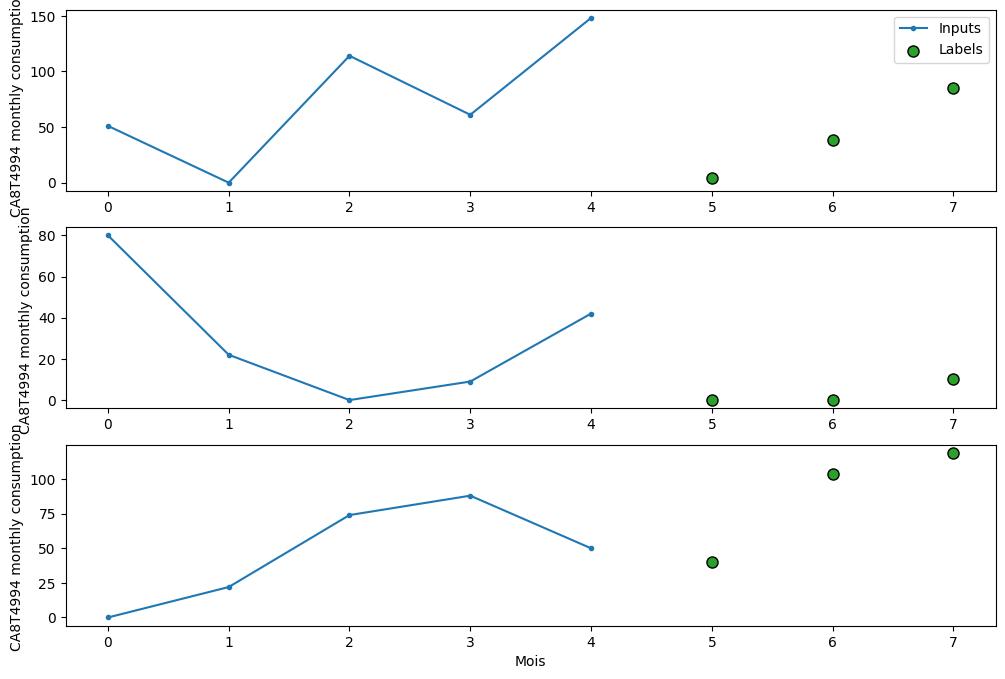

In [1089]:

multi_window = WindowGenerator(input_width=input_width,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Single-shot models

One high-level approach to this problem is to use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `tf.keras.layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predict all timesteps from the last time-step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_dense.png?raw=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0278 - mean_absolute_error: 0.1228 


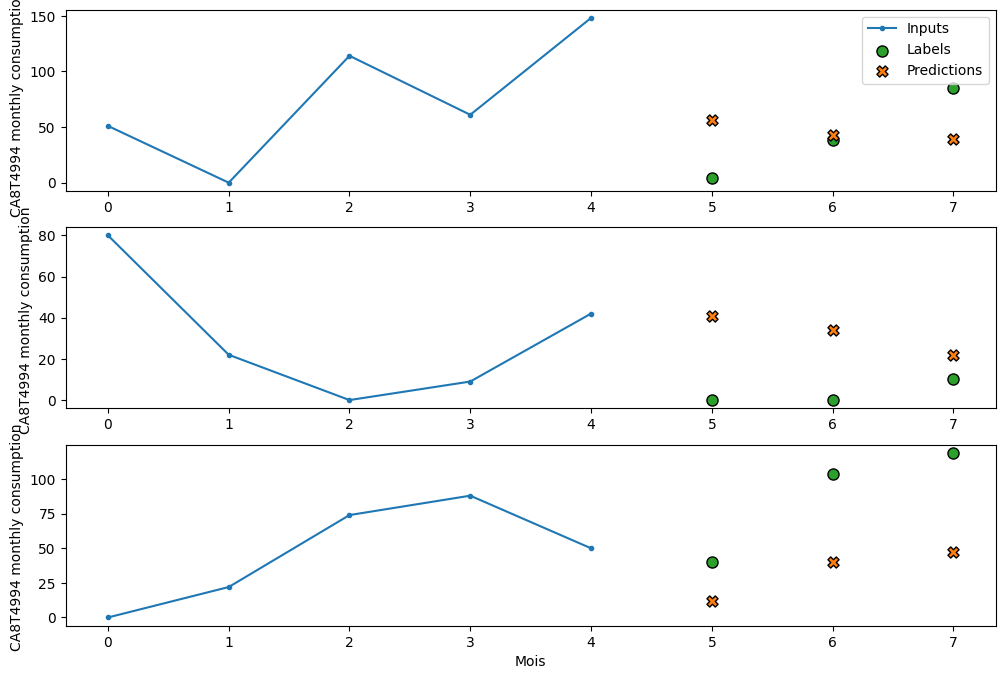

In [1090]:
multi_val_performance = {}
multi_performance = {}

multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_linear_model)

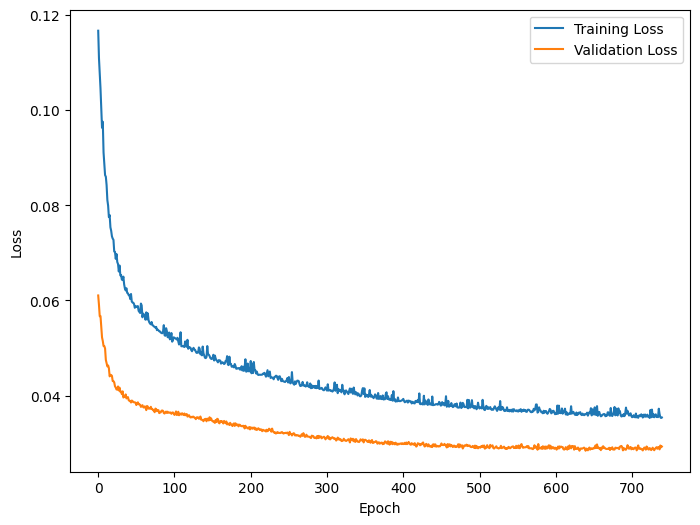

In [1091]:
# Get the loss values from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss values
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Dense

Adding a `tf.keras.layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input time step.

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.0294 - mean_absolute_error: 0.1241  


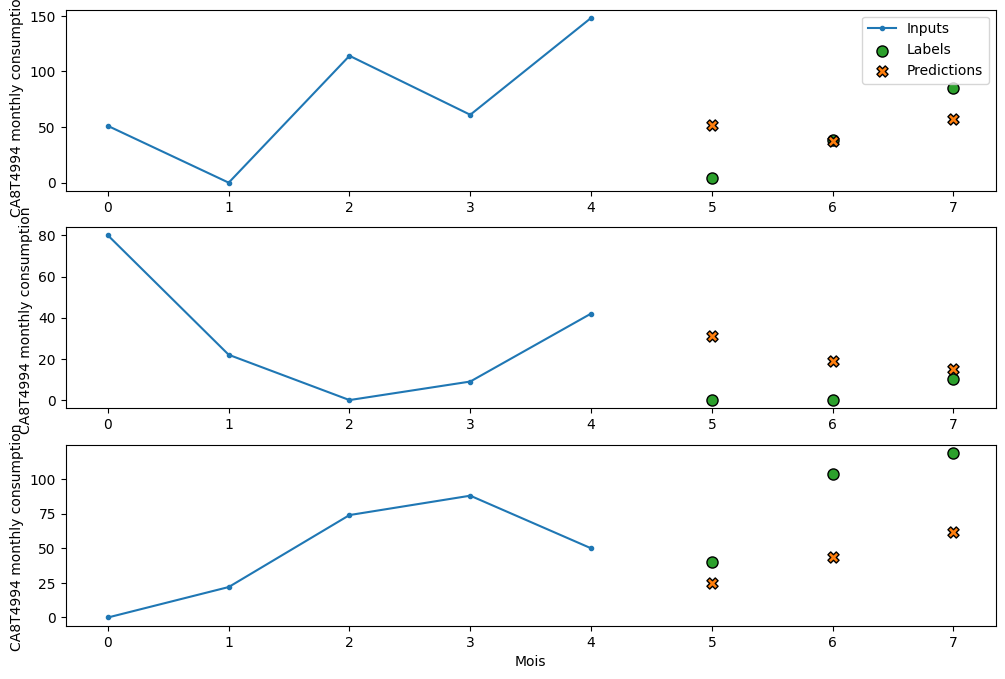

In [1092]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(256, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_dense_model)

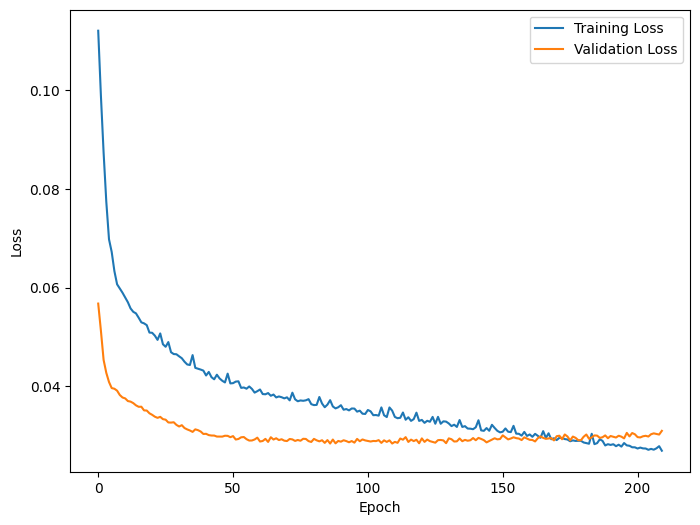

In [1093]:
# Get the loss values from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss values
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_conv.png?raw=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.0317 - mean_absolute_error: 0.1298  


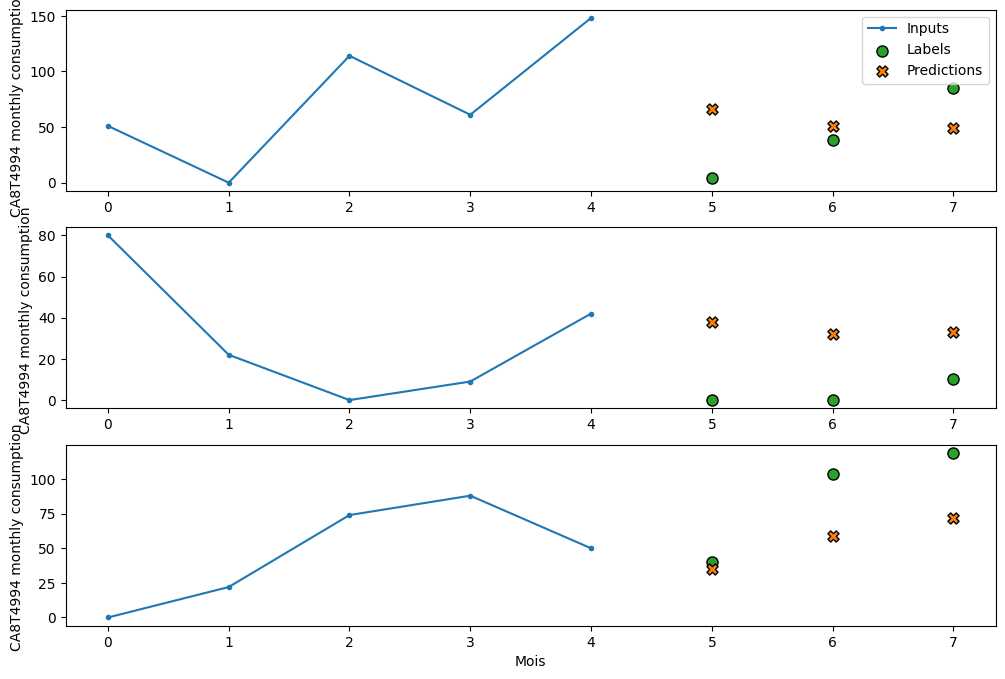

In [1094]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dropout(0.1),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_conv_model)

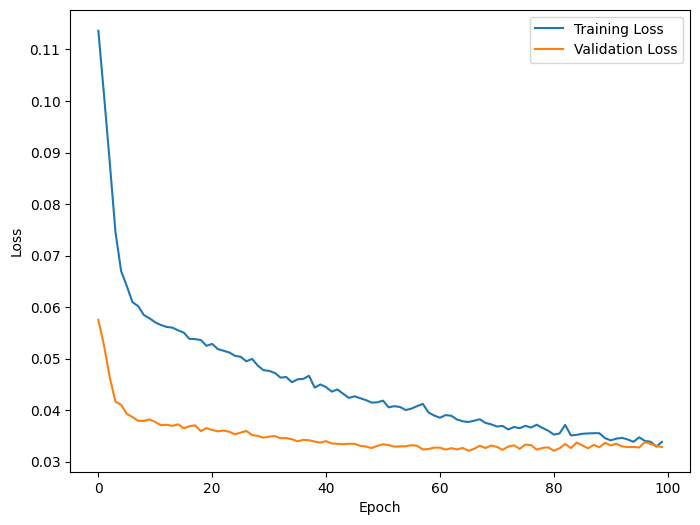

In [1095]:
# Get the loss values from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss values
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24 hours, before making a single prediction for the next 24 hours.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False` in `tf.keras.layers.LSTM`.

![The LSTM accumulates state over the input window, and makes a single prediction for the next 24 hours](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_lstm.png?raw=1)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 0.0351 - mean_absolute_error: 0.1290


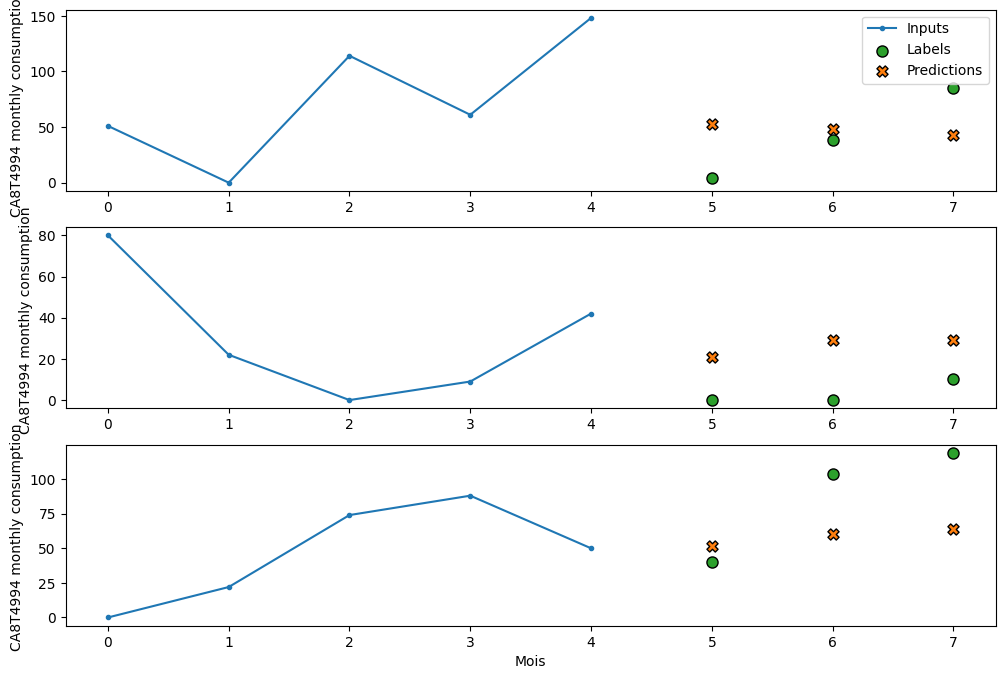

In [1096]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dense(156, activation='relu'),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),

    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_lstm_model)

In [1097]:
multi_lstm_model.summary()

Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 128)            │        79,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 156)            │        20,124 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 78)             │        12,246 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_71 (Reshape)            │ (None, 3, 26)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 335,192 (1.28 MB)

 Trainable params: 111,730 (436.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 223,462 (872.90 KB)

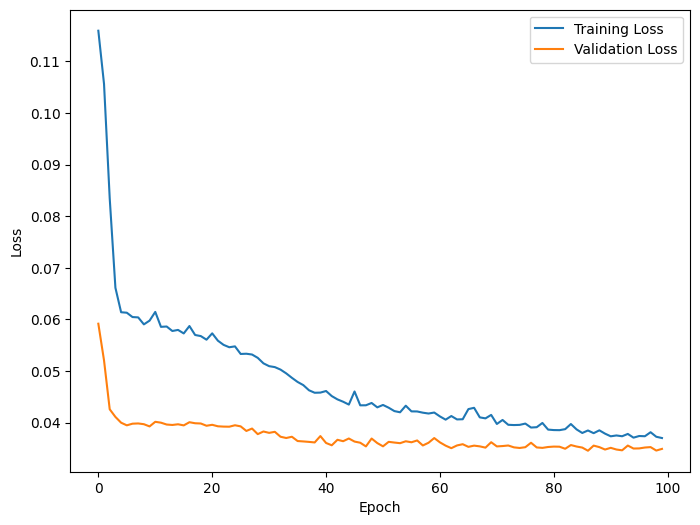

In [1098]:
# Get the loss values from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss values
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [1099]:
# plot_model(multi_lstm_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [1100]:
# import visualkeras

# model = wide_conv_window.plot(conv_model)


# visualkeras.layered_view(model).show() # display using your system viewer
# visualkeras.layered_view(model, to_file='output.png') # write to disk
# visualkeras.layered_view(model, to_file='output.png').show() # write and show

# visualkeras.layered_view(model)

### Advanced: Autoregressive model

The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then, each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic <a href="https://arxiv.org/abs/1308.0850" class="external">Generating Sequences With Recurrent Neural Networks</a>.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half of this tutorial and run in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_autoregressive.png?raw=1)

#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single time step.

The model will have the same basic form as the single-step LSTM models from earlier: a `tf.keras.layers.LSTM` layer followed by a `tf.keras.layers.Dense` layer that converts the `LSTM` layer's outputs to model predictions.

A `tf.keras.layers.LSTM` is a `tf.keras.layers.LSTMCell` wrapped in the higher level `tf.keras.layers.RNN` that manages the state and sequence results for you (Check out the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide for details).

In this case, the model has to manually manage the inputs for each step, so it uses `tf.keras.layers.LSTMCell` directly for the lower level, single time step interface.

In [1101]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [1102]:
feedback_model = FeedBack(units=128, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained, this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [1103]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction and the internal state of the `LSTM`:

In [1104]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([3, 26])

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach for collecting the output predictions is to use a Python list and a `tf.stack` after the loop.

Note: Stacking a Python list like this only works with eager-execution, using `Model.compile(..., run_eagerly=True)` for training, or with a fixed length output. For a dynamic output length, you would need to use a `tf.TensorArray` instead of a Python list, and `tf.range` instead of the Python `range`.

In [1105]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Test run this model on the example inputs:

In [1106]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (3, 3, 26)


Now, train the model:

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0368 - mean_absolute_error: 0.1342 


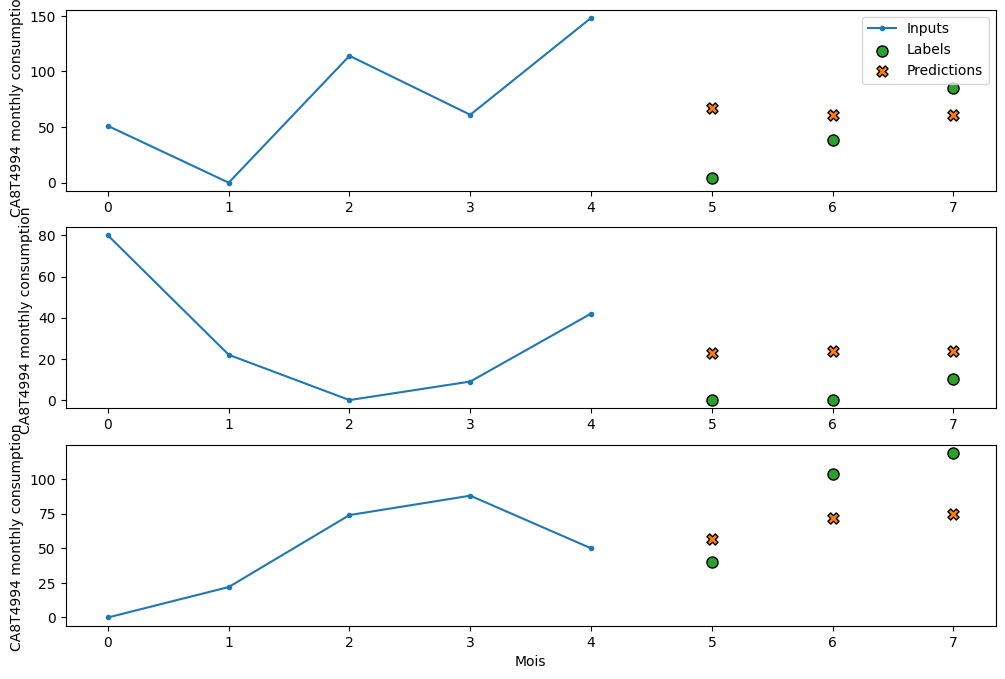

In [1107]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, return_dict=True)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(feedback_model)

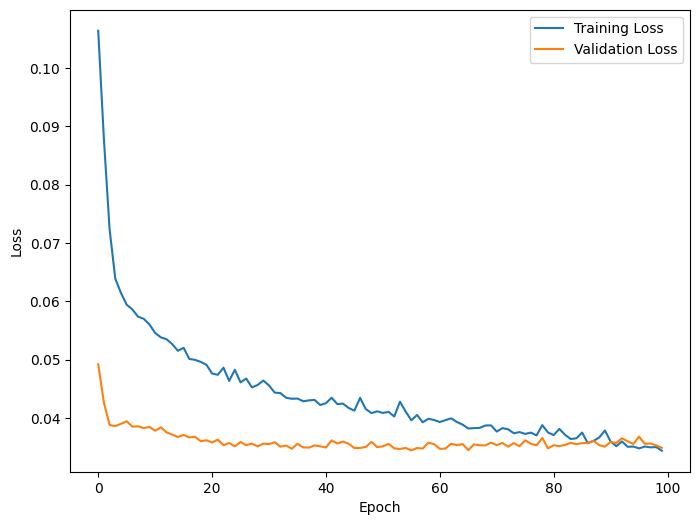

In [1108]:
# Get the loss values from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss values
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Performance

There are clearly diminishing returns as a function of model complexity on this problem:

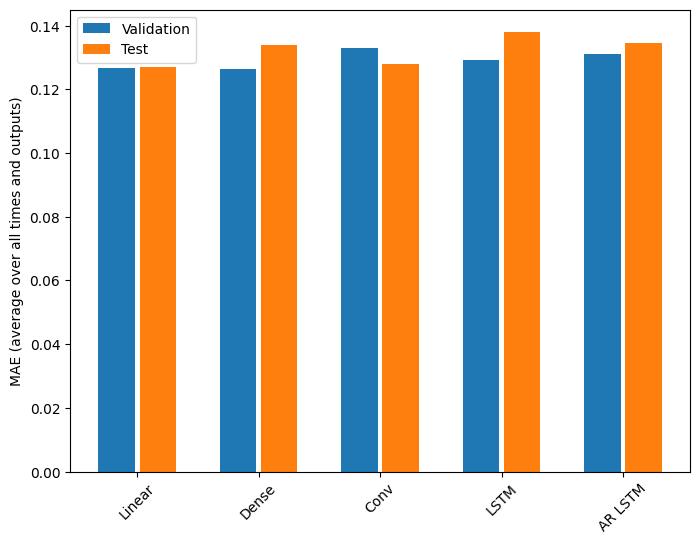

In [1109]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in multi_val_performance.values()]
test_mae = [v[metric_name] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

# import the best model and use it

In [1110]:
best_model = keras.models.load_model(checkpoint_filepath, safe_mode=False)

### PLOT ON RANDOM EXAMPLES

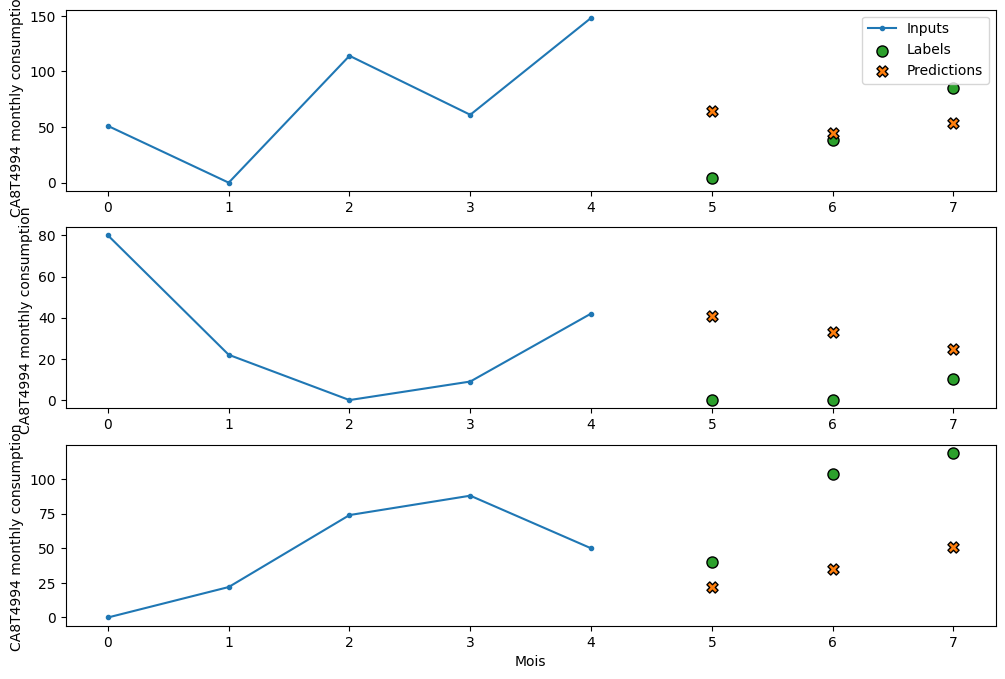

In [1111]:
multi_window.plot(best_model)

In [1112]:
multi_window.plot2(best_model)

### Plot on the last 5 months and the forecast on 3 months

In [1113]:

data_test = final_data[-(input_width + OUT_STEPS ):]
print(data_test.shape)
last_prediction = WindowGenerator(input_width=input_width,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,final_data = data_test )

# last_prediction.plot()
# last_prediction

(8, 26)


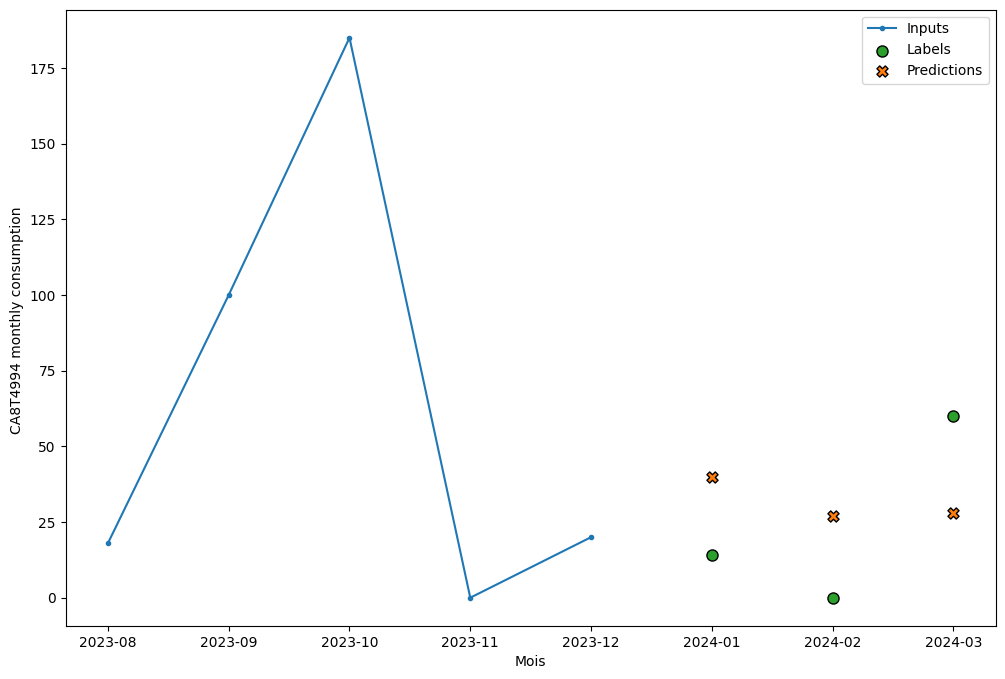

In [1114]:
last_prediction.plot_last(best_model)

In [1115]:
last_prediction.plot_last2(best_model)

In [1116]:
def plot_final_prediction(self,model=best_model,plot_col=etude,):
    plt.figure(figsize=(12, 8))
    # OUT_STEPS = 3
    # plot_col_index = 8
    plot_col_index = self.column_indices[plot_col]
    data_final_plot = final_data[-self.input_width:]
    data_final_plot = np.array(data_final_plot, dtype=np.float32)
    tensor_data = tf.convert_to_tensor(data_final_plot, dtype=tf.float32)
    tensor_data = tf.expand_dims(tensor_data, 0)  # Reshape tensor_data to match the model's input shape
    predictions = model(tensor_data)
    # print(tensor_data.shape)
    modified_predictions = predictions.numpy()  # Convert the EagerTensor to a NumPy array
    targeted_date = month_year[-self.input_width:]
    targeted_date = np.array(targeted_date)

    # Convert the last date in targeted_date back to datetime format
    last_date = datetime.datetime.strptime(targeted_date[-1], '%Y-%m')

    # Calculate the next 3 dates
    next_dates = [last_date + relativedelta(months=i) for i in range(1, self.label_width+1)]

    # Convert the next_dates to the desired format
    next_dates_formatted = [date.strftime('%Y-%m') for date in next_dates]

    # Extend the targeted_date list with the next_dates_formatted
    targeted_date = np.concatenate((targeted_date, next_dates_formatted))
    # print(targeted_date)

    # print(targeted_date[-(self.label_width+self.input_width):-self.input_width])

    modified_predictions[0, :, plot_col_index] = modified_predictions[0, :, plot_col_index] * (train_max[etude]-train_min[etude]) + train_min[etude]
    final_predictions = modified_predictions[0, :, plot_col_index]
    final_predictions = [math.ceil(x) for x in final_predictions]
    # print(final_predictions)

    modified_inputs = tensor_data.numpy()
    modified_inputs[0, :, plot_col_index] = modified_inputs[0, :, plot_col_index] * (train_max[etude]-train_min[etude]) + train_min[etude]
    # print(self.input_width)
    # print(self.label_width)
    # print(targeted_date[-(self.input_width + self.label_width):-self.label_width])
    # print(modified_inputs[0, :, plot_col_index])
    plt.plot(targeted_date[-(self.input_width + self.label_width):-self.label_width], modified_inputs[0, :, plot_col_index],label='Inputs', marker='.', zorder=-10)

    plt.scatter(targeted_date[-self.label_width:], final_predictions,marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)
    # print("Predictions :",final_predictions)
    plt.xlabel('Mois')
    plt.ylabel(f'{etude_print} monthly consumption')
    plt.legend()
    plt.title("the inputs of the last 5 months and the prediction of the coming 3 months")


WindowGenerator.plot_final_prediction = plot_final_prediction

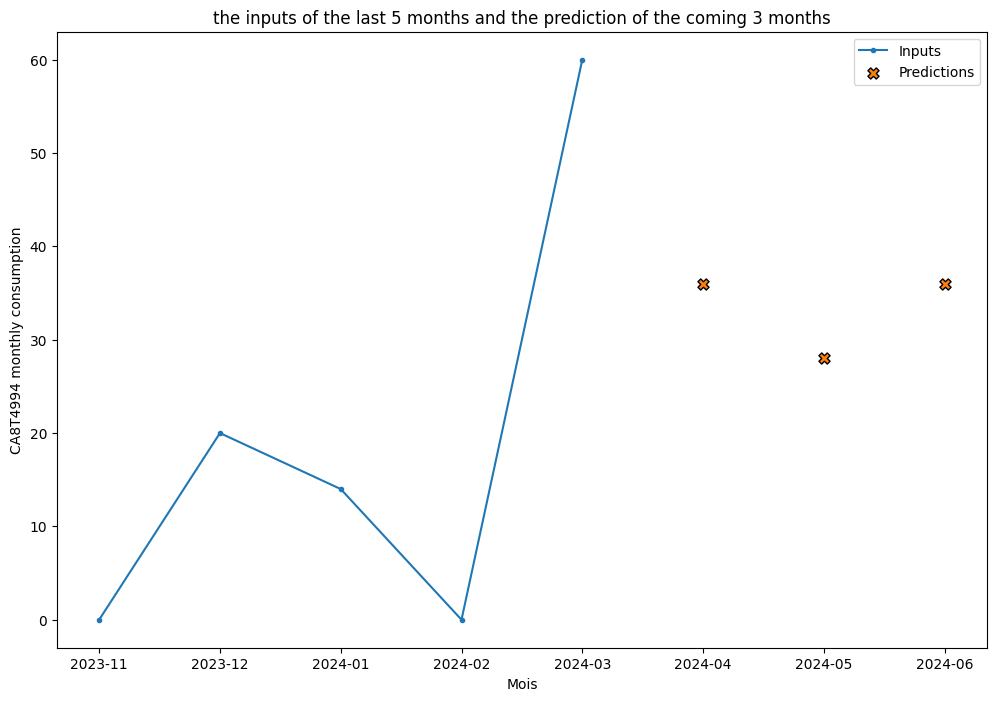

In [1117]:
last_prediction.plot_final_prediction()

In [1118]:
def plot_final_prediction2(self,model=best_model,plot_col=etude,):
    # plt.figure(figsize=(12, 8))
    # OUT_STEPS = 3
    # plot_col_index = 8
    fig = go.Figure()
    plot_col_index = self.column_indices[plot_col]
    data_final_plot = final_data[-self.input_width:]
    data_final_plot = np.array(data_final_plot, dtype=np.float32)
    tensor_data = tf.convert_to_tensor(data_final_plot, dtype=tf.float32)
    tensor_data = tf.expand_dims(tensor_data, 0)  # Reshape tensor_data to match the model's input shape
    predictions = model(tensor_data)
    # print(tensor_data.shape)
    modified_predictions = predictions.numpy()  # Convert the EagerTensor to a NumPy array
    targeted_date = month_year[-self.input_width:]
    targeted_date = np.array(targeted_date)

    # Convert the last date in targeted_date back to datetime format
    last_date = datetime.datetime.strptime(targeted_date[-1], '%Y-%m')

    # Calculate the next 3 dates
    next_dates = [last_date + relativedelta(months=i) for i in range(1, self.label_width+1)]

    # Convert the next_dates to the desired format
    next_dates_formatted = [date.strftime('%Y-%m') for date in next_dates]

    # Extend the targeted_date list with the next_dates_formatted
    targeted_date = np.concatenate((targeted_date, next_dates_formatted))

    # print(targeted_date[-(self.label_width+self.input_width):-self.input_width])

    modified_predictions[0, :, plot_col_index] = modified_predictions[0, :, plot_col_index] * (train_max[etude]-train_min[etude]) + train_min[etude]
    final_predictions = modified_predictions[0, :, plot_col_index]
    final_predictions = [math.ceil(x) for x in final_predictions]
    # print(final_predictions)

    modified_inputs = tensor_data.numpy()
    modified_inputs[0, :, plot_col_index] = modified_inputs[0, :, plot_col_index] * (train_max[etude]-train_min[etude]) + train_min[etude]

    fig.add_trace(go.Scatter(x=targeted_date[-(self.input_width + self.label_width):-self.label_width], y=modified_inputs[0, :, plot_col_index],
                                 mode='lines', name='Inputs'))
    fig.add_trace(go.Scatter(x=targeted_date[-(self.input_width + self.label_width):-self.label_width], y=modified_inputs[0, :, plot_col_index],
                                 mode='markers', name='Inputs'))


    fig.add_trace(go.Scatter(x=targeted_date[-self.label_width:], y=final_predictions,
                                 mode='markers', name='Predictions'))
   
    # print("Predictions :",final_predictions)
    fig.update_layout(
    # title=f'{etude_print} monthly consumption',
    xaxis_title='Mois',
    yaxis_title=f'{etude_print} monthly consumption'
    )

    # Show the plot
    fig.show()



WindowGenerator.plot_final_prediction2 = plot_final_prediction2

In [1119]:
last_prediction.plot_final_prediction2()